In [54]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
# See https://duetosymmetry.com/code/latex-mpl-fig-tips/
plt.style.use("mda.mplstyle")

pt = 1./72.27 # Hundreds of years of history... 72.27 points to an inch.

jour_sizes = {"PRD": {"onecol": 246.*pt, "twocol": 510.*pt},
              "CQG": {"onecol": 374.*pt}, # CQG is only one column
              # Add more journals below. Can add more properties to each journal
             }

my_width = jour_sizes["PRD"]["onecol"]
# Our figure's aspect ratio
golden = (1 + 5 ** 0.5) / 2

## RMSD of Zebrafish Hb only

In [31]:
from MDAnalysis.analysis import rms
#Read all the trajectories
protein_prod = mda.Universe('zeb_hb_only_sim/sys_prod/prod_zeb_hb_only.gro', 'zeb_hb_only_sim/sys_prod/prod_zeb_hb_only_compact_compact.xtc')

R = rms.RMSD(protein_prod,  # universe to align
    protein_prod,  # reference universe or atomgroup
    select='backbone',  # group to superimpose and calculate RMSD
    ref_frame=0)  # frame index of the reference

R.run()
times_p = R.results.rmsd[:,1]
rmsd_p = R.results.rmsd[:,2]

## Radius of Gyration of Zebrafish Hb only

In [24]:
group = protein_prod.select_atoms('protein')		# change the atom selection for your specific system

Frame = []
times = []
Rgyr = []
for ts in protein_prod.trajectory:
	Frame.append(ts.frame)
	times.append(protein_prod.trajectory.time)
	Rgyr.append(group.radius_of_gyration())

Rgyrp_table = np.vstack((Frame, times, Rgyr)).T

## RMSD of Zebrafish Hb and PHZ Complex

In [17]:
from MDAnalysis.analysis import rms
#Read all the trajectories
complex_prod = mda.Universe('zeb_hb_phz_complex_sim/sys_prod/prod_zeb_hb_phz_complex.gro', 'zeb_hb_phz_complex_sim/sys_prod/prod_zeb_hb_phz_complex_compact_compact.xtc')

R = rms.RMSD(complex_prod,  # universe to align
    complex_prod,  # reference universe or atomgroup
    select='backbone',  # group to superimpose and calculate RMSD
    ref_frame=0)  # frame index of the reference

R.run()
times_c = R.results.rmsd[:,1]
rmsd_c = R.results.rmsd[:,2]

## Radius of Gyration of Zebrafish Hb and PHZ Complex

In [44]:
group = complex_prod.select_atoms('protein')		# change the atom selection for your specific system

Frame = []
times = []
Rgyr = []
for ts in complex_prod.trajectory:
	Frame.append(ts.frame)
	times.append(complex_prod.trajectory.time)
	Rgyr.append(group.radius_of_gyration())

Rgyrc_table = np.vstack((Frame, times, Rgyr)).T

## Plot everything

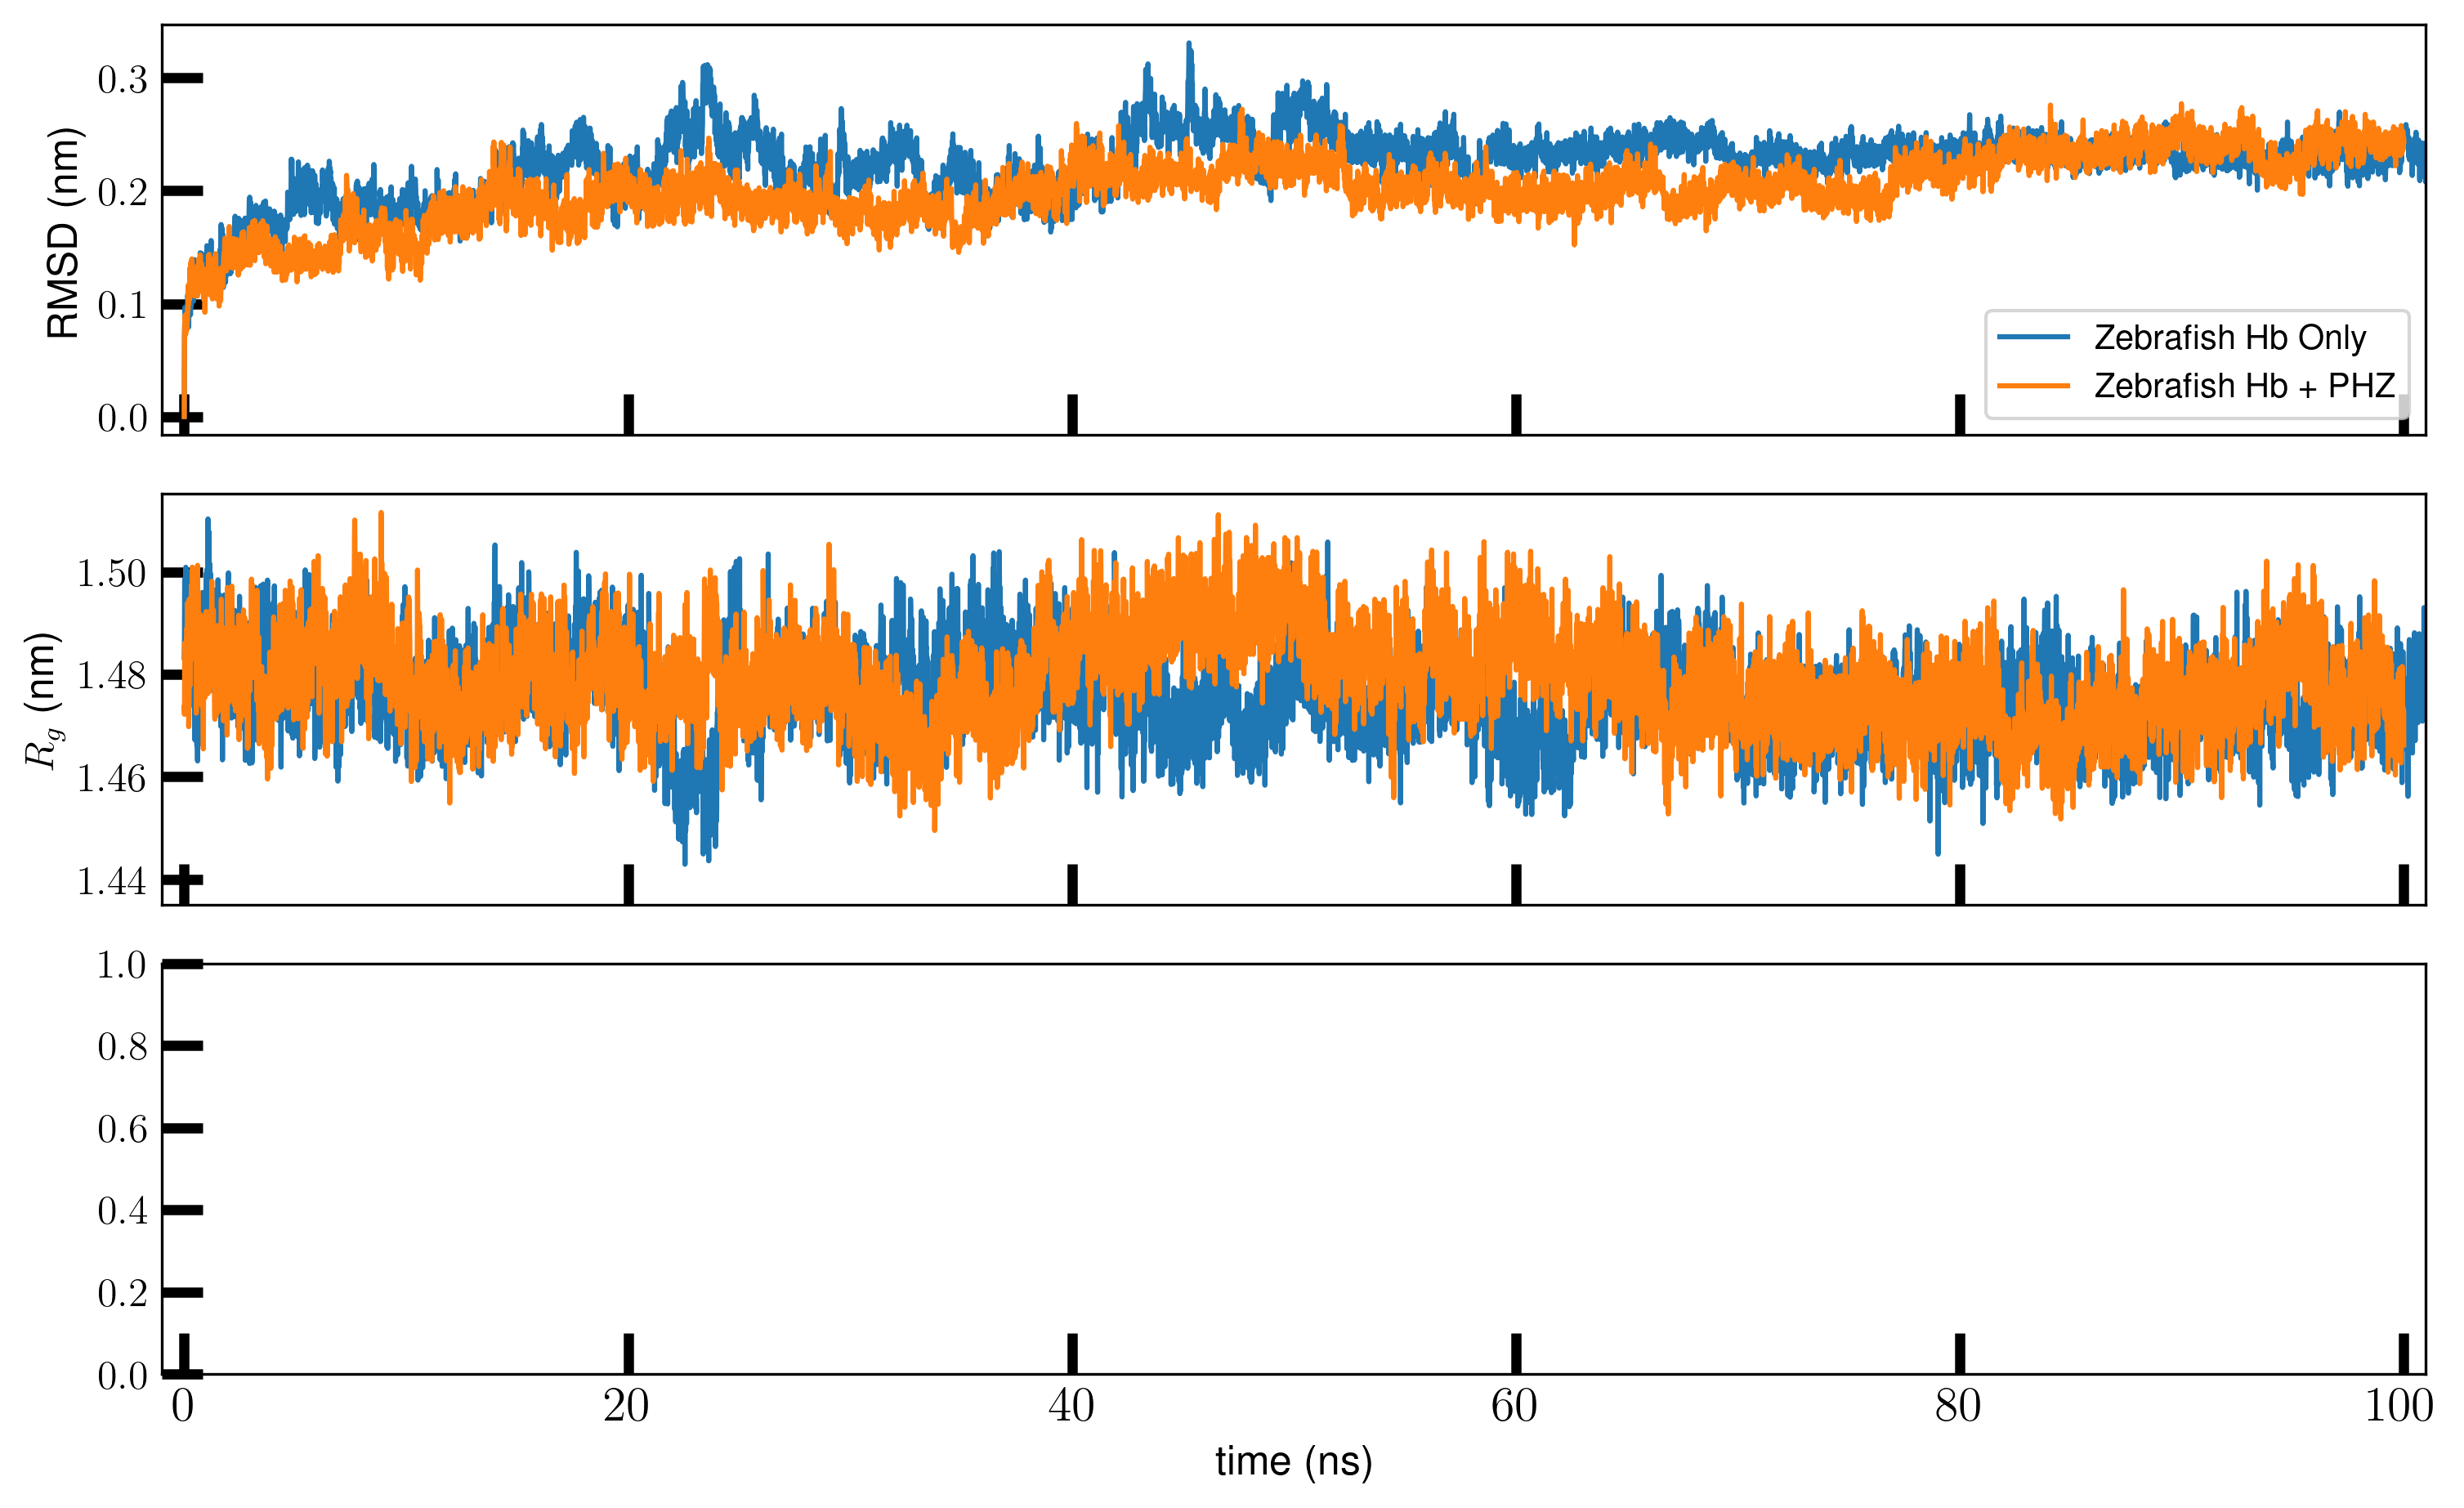

In [50]:
npanels = 3
fig, axs = plt.subplots(npanels,1, sharex=True, tight_layout=True, figsize = (npanels * my_width, npanels*my_width/golden))

ax_rmsd = axs[0]
ax_rmsd.set_ylabel(r'RMSD (nm)');

ax_rmsd.plot(times_p/1000, rmsd_p/10, label="Zebrafish Hb Only")
ax_rmsd.plot(times_c/1000, rmsd_c/10, label="Zebrafish Hb + PHZ")

ax_rmsd.legend()

ax_rg = axs[1]
ax_rg.plot(Rgyrp_table[:,1]/1000, Rgyrp_table[:,2]/10, label="Zebrafish Hb Only")
ax_rg.plot(Rgyrc_table[:,1]/1000, Rgyrc_table[:,2]/10, label="Zebrafish Hb + PHZ")
ax_rg.set_ylabel(r'$R_g$ (nm)');

ax_bonds = axs[2]
ax_bonds.set_xlabel(r'time (ns)');
ax_bonds.set_xlim(-1, 101);


## RMSF: Protein backbone and Carbon alpha

In [69]:
c_alphas_p = protein_prod.select_atoms('protein and name CA')
R_p = rms.RMSF(c_alphas_p).run()

c_alphas_c = complex_prod.select_atoms('protein and name CA')
R_c = rms.RMSF(c_alphas_c).run()


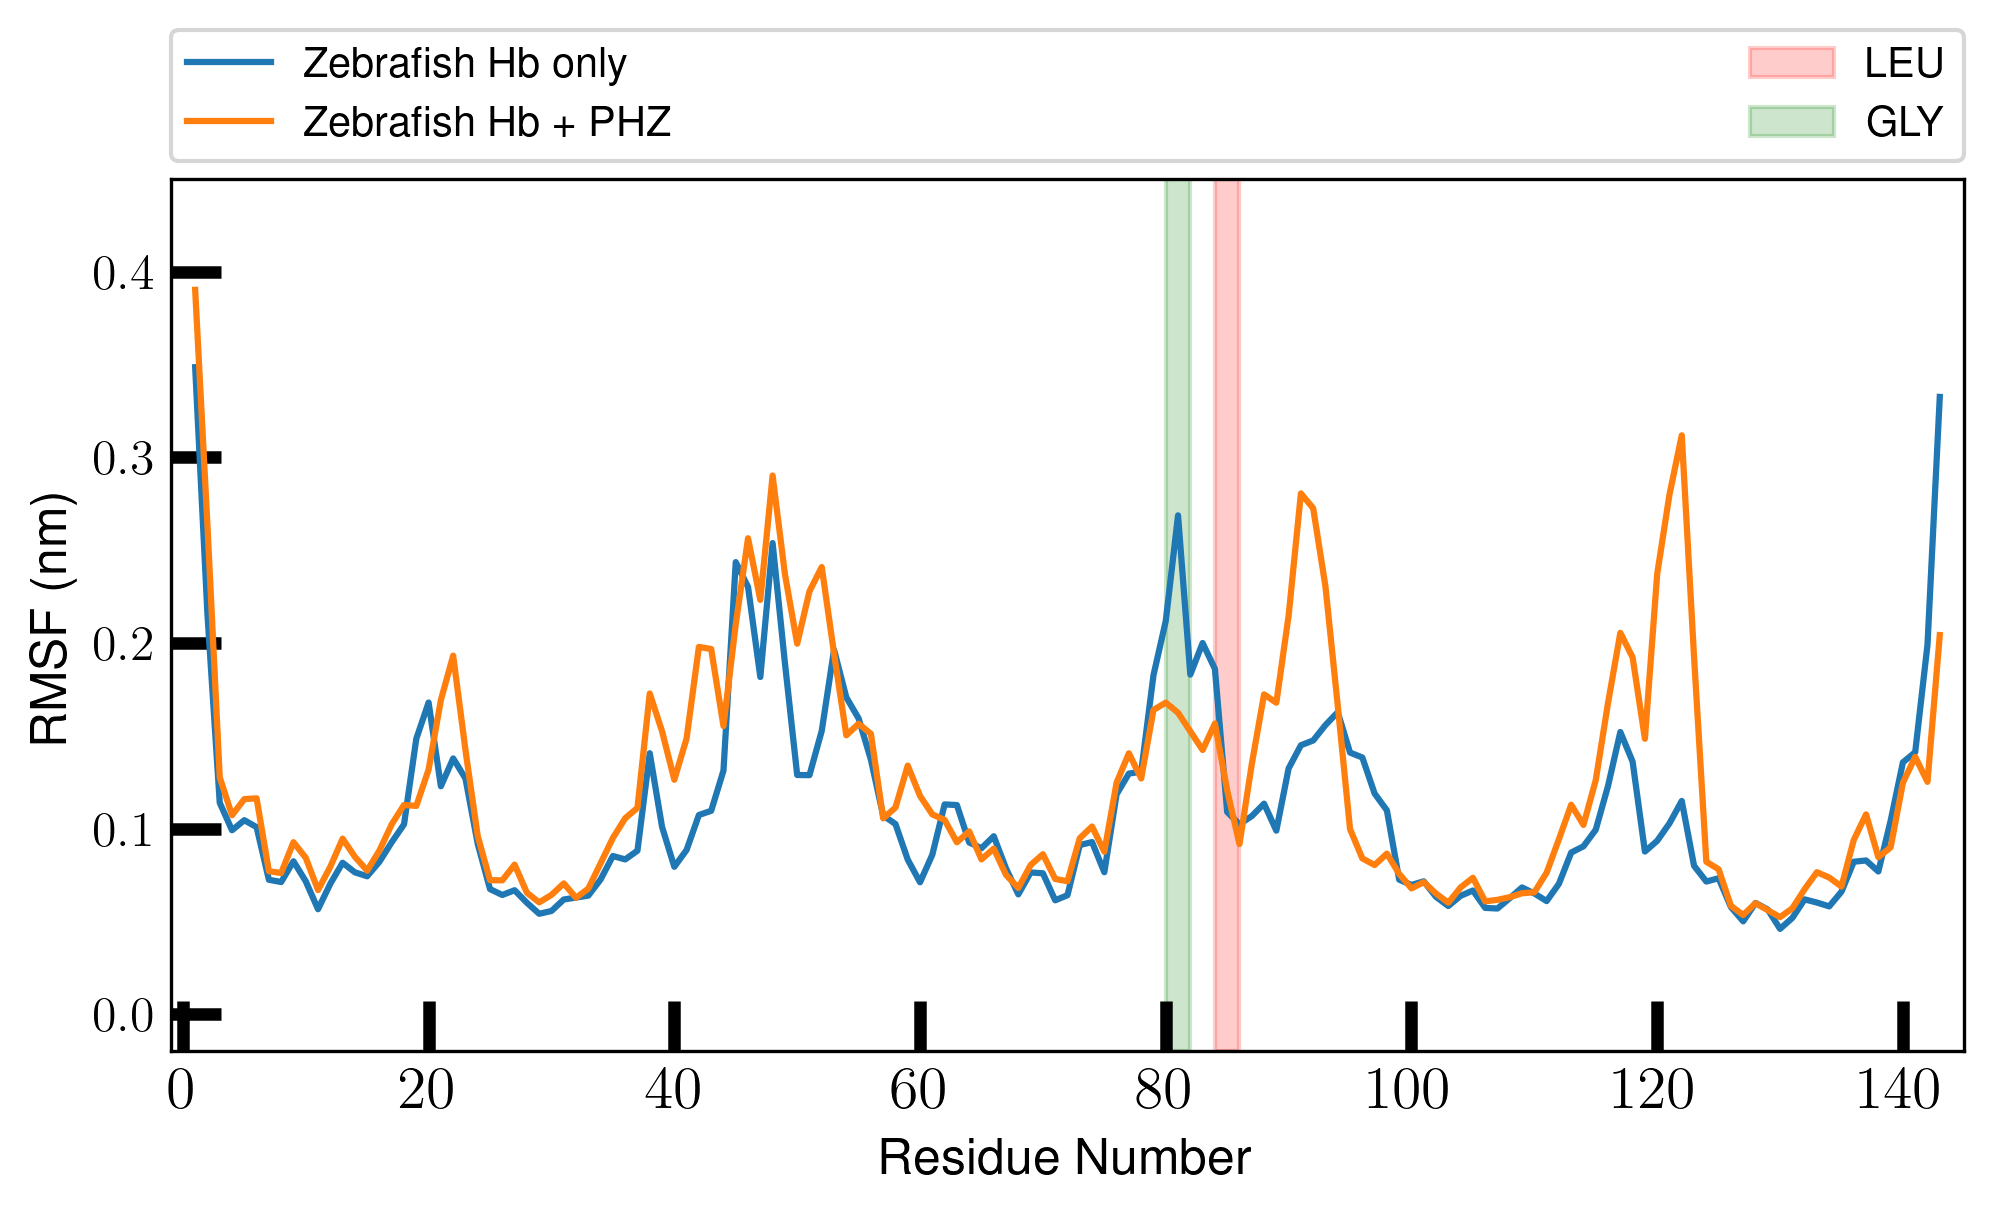

In [101]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (2*my_width, 2*my_width/golden))
plt.plot(c_alphas_p.resids, R_p.results.rmsf/10, label="Zebrafish Hb only")
plt.plot(c_alphas_c.resids, R_c.results.rmsf/10, label="Zebrafish Hb + PHZ")
plt.axvspan(84, 86, zorder=0, alpha=0.2, color='red', label='LEU')
plt.axvspan(80, 82, zorder=0, alpha=0.2, color='green', label='GLY')
plt.xlabel('Residue Number')
plt.ylabel('RMSF (nm)')
plt.xlim(-1, 145)
plt.ylim(-0.02, 0.45)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
            ncols=2, mode="expand", borderaxespad=0.)

In [91]:
residues = protein_prod.select_atoms('resid 81')
residues.resnames

array(['GLY', 'GLY', 'GLY', 'GLY', 'GLY', 'GLY', 'GLY'], dtype=object)

## TODO: RMSF & h-bond stuff

In [ ]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt


# Calculate RMSF
rmsf_protein_water = mda.analysis.rms.rmsf(protein_water, select='protein')
rmsf_protein_water.run()
rmsf_protein_ligand = mda.analysis.rms.rmsf(protein_ligand, select='protein')
rmsf_protein_ligand.run()

# Perform hydrogen bond analysis: Atao bhul: https://docs.mdanalysis.org/2.0.0/documentation_pages/analysis/hydrogenbonds.html
hba_protein_ligand = mda.analysis.hbonds.HydrogenBondAnalysis(protein_ligand, 'protein', 'ligand')
hba_protein_ligand.run()



# Hydrogen Bond Analysis plot
axes[1, 1].plot(hba_protein_ligand.timeseries[:, 0], hba_protein_ligand.timeseries[:, 1])
axes[1, 1].set_xlabel('Time (ps)')
axes[1, 1].set_ylabel('Number of Hydrogen Bonds')

plt.tight_layout()
plt.show()